<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.4/MathJax.js?config=default'></script>

# Tutorial: POD-ESN model of a 2D cylinder flow

The aim of a `POD-ESN` object is to create a reduced order model of a dataset (2D velocity fields in this case) by first, performing proper orthogonal decomposition (POD) on the data and then train an echo state network (ESN) to learn the temporal evolution of the POD coefficients. 

The class `POD-ESN` from `src.models_datadriven` combines two parent classes:
1. `POD` $\rightarrow$ tutorial `03_Class POD` gives further details on this object. 
2. `ESN_model` $\rightarrow$ tutorial `03_Class ESN_model` gives further details on this object.

<br>


This notebook is divided in two parts: 
* [Part I. Apply POD to the dataset with `ML_models.POD`](#part1)
* [Part II. Reduced order modelling via POD-ESN from `src.models_datadriven.POD-ESN`](#part2)

First, let's load and visualize the dataset we will be working with. 


In [1]:
from src.utils import set_working_directories, load_from_mat_file, add_noise_to_flow, get_wake_data
import numpy as np
from src.utils import animate_flowfields


# Define woking directories
data_folder, results_folder, figs_folder = set_working_directories('wakes')

get_wake_data(data_folder)


# Load dataset
mat = load_from_mat_file(data_folder + '/circle_re_100.mat')
Ux, Uy, P = [mat[key] for key in ['ux', 'uy', 'pp']]
        
# Visualize the flow fields
anim = animate_flowfields([Ux, Uy, P], titles=['$U_x$', '$U_y$', '$P$'])
anim

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10d678e90>>
Traceback (most recent call last):
  File "/Users/anovoama/anaconda3/envs/real-time-da/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


: 

: 

# Part I. Apply POD to the dataset with `ML_models.POD` <a name="part1"></a>
We apply POD to the velocity fielsd $u=[U_x; U_y]$ only because the flow is incompressible. This is because the velocity components carry most of the total kinetic energy (TKE) in a turbulent or unsteady flow.
The pressure field does not directly contribute to TKE but rather acts as a constraint on the velocity field via the Navier-Stokes equations, specifically $P$ is often computed indirectly from the incompressible constraint ($\nabla\cdot u$) and it exhibits different spatial structures compared to velocity



## 1. Data preparation <a name="part1-1"></a>
- Add noise to the data to mimic PIV measurements.
- Split the data, i.e., divide the dataset into (i) data to run the POD and train and validate the ESN, and (ii)data to test the POD-ESN model.

In [ ]:


Ux_noisy, Uy_noisy = add_noise_to_flow(Ux, Uy, 
                                       noise_level=0.1, 
                                       noise_type="gauss",
                                       spatial_smooth=0.1)


data = np.array([Ux_noisy, Uy_noisy])

all_data = data.transpose(0,3,2,1)
Nt_train = 400

X_train = all_data[..., :Nt_train].copy()
X_test = all_data[..., Nt_train:].copy()


# This is the _true_ data, which is never seen by the POD-ESN
data_true = np.array([Ux, Uy])
all_data_true = data_true.transpose(0,3,2,1)
X_test_true = all_data_true[..., Nt_train:].copy()


# Visualize the flow fields
anim = animate_flowfields([Ux_noisy, Uy_noisy], titles=['$U_x$', '$U_y$'])
anim


## Initialize POD instance <a name="part1-1"></a>


In [ ]:

from src.ML_models.POD import POD

case_pod = POD(X = X_train, 
               N_modes=100,
              domain=[-2, 2, 0, 12])

MODULO (MODal mULtiscale pOd) is a software developed at the von Karman Institute to perform data driven modal decomposition of numerical and experimental data. 

Modulo assumes you have a uniform grid. If not, please give the weights as parameters of MODULO!
Computing correlation matrix...
Computing Temporal correlation matrix K ...
Done.
Computing Temporal Basis...
Diagonalizing K...
Done.
Computing Spatial Basis...
Computing Phi from D...
Done.


## POD eigenvalues and the POD basis <a name="part1-3"></a> 
The eigenvalues contain the kinetic energy of the flow. With only 400 snapshots the POD decomposition is not yet converged as the two lines do not match. 

In [ ]:
case_pod.N_modes, X_trainz

100

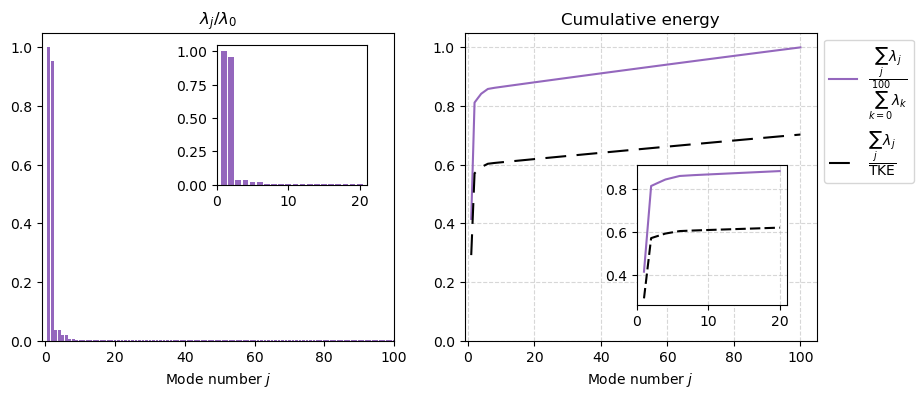

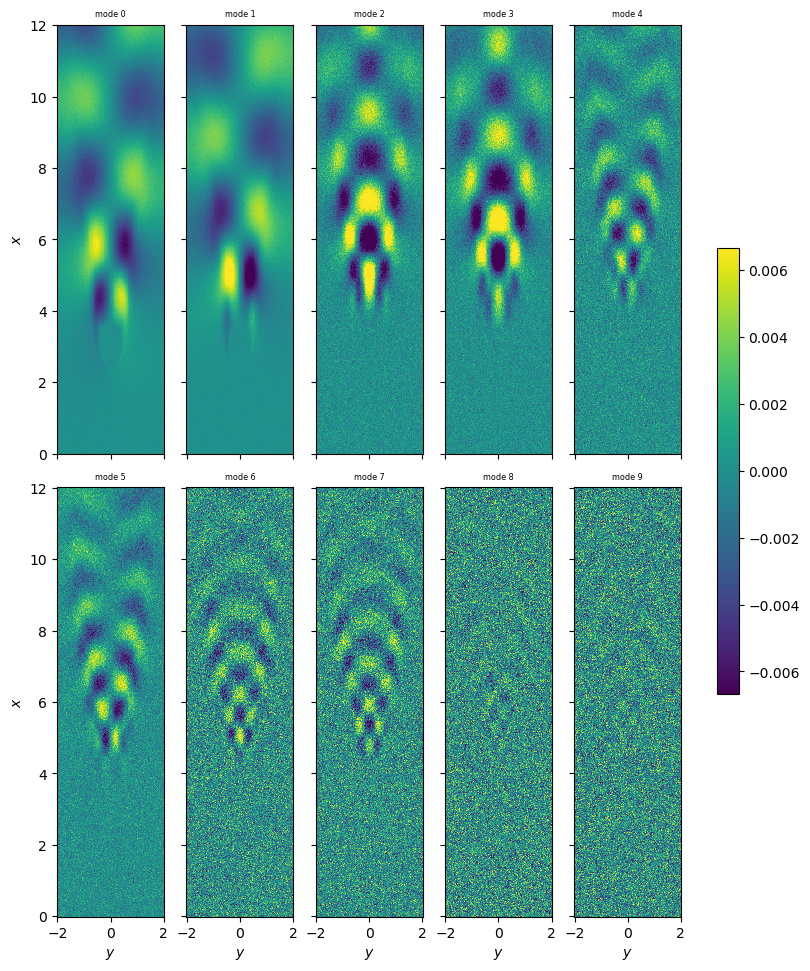

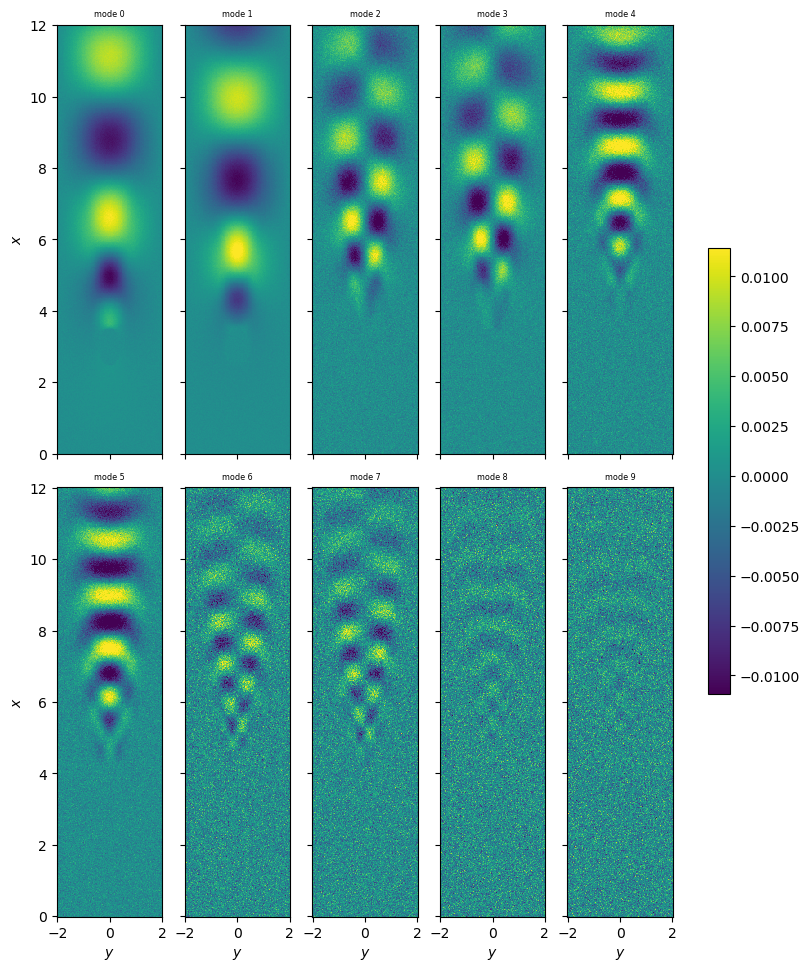

In [ ]:

POD.plot_spectrum(case=case_pod, max_mode=20)
POD.plot_POD_modes(case=case_pod, num_modes=10)

## Flow reconstuction <a name="part1-4"></a>

We can see that most of the energy is concentrated on the first two modes, reaching over 95% of the TKE of the system. Let's now visualize the reconstruction for different number of modes. 

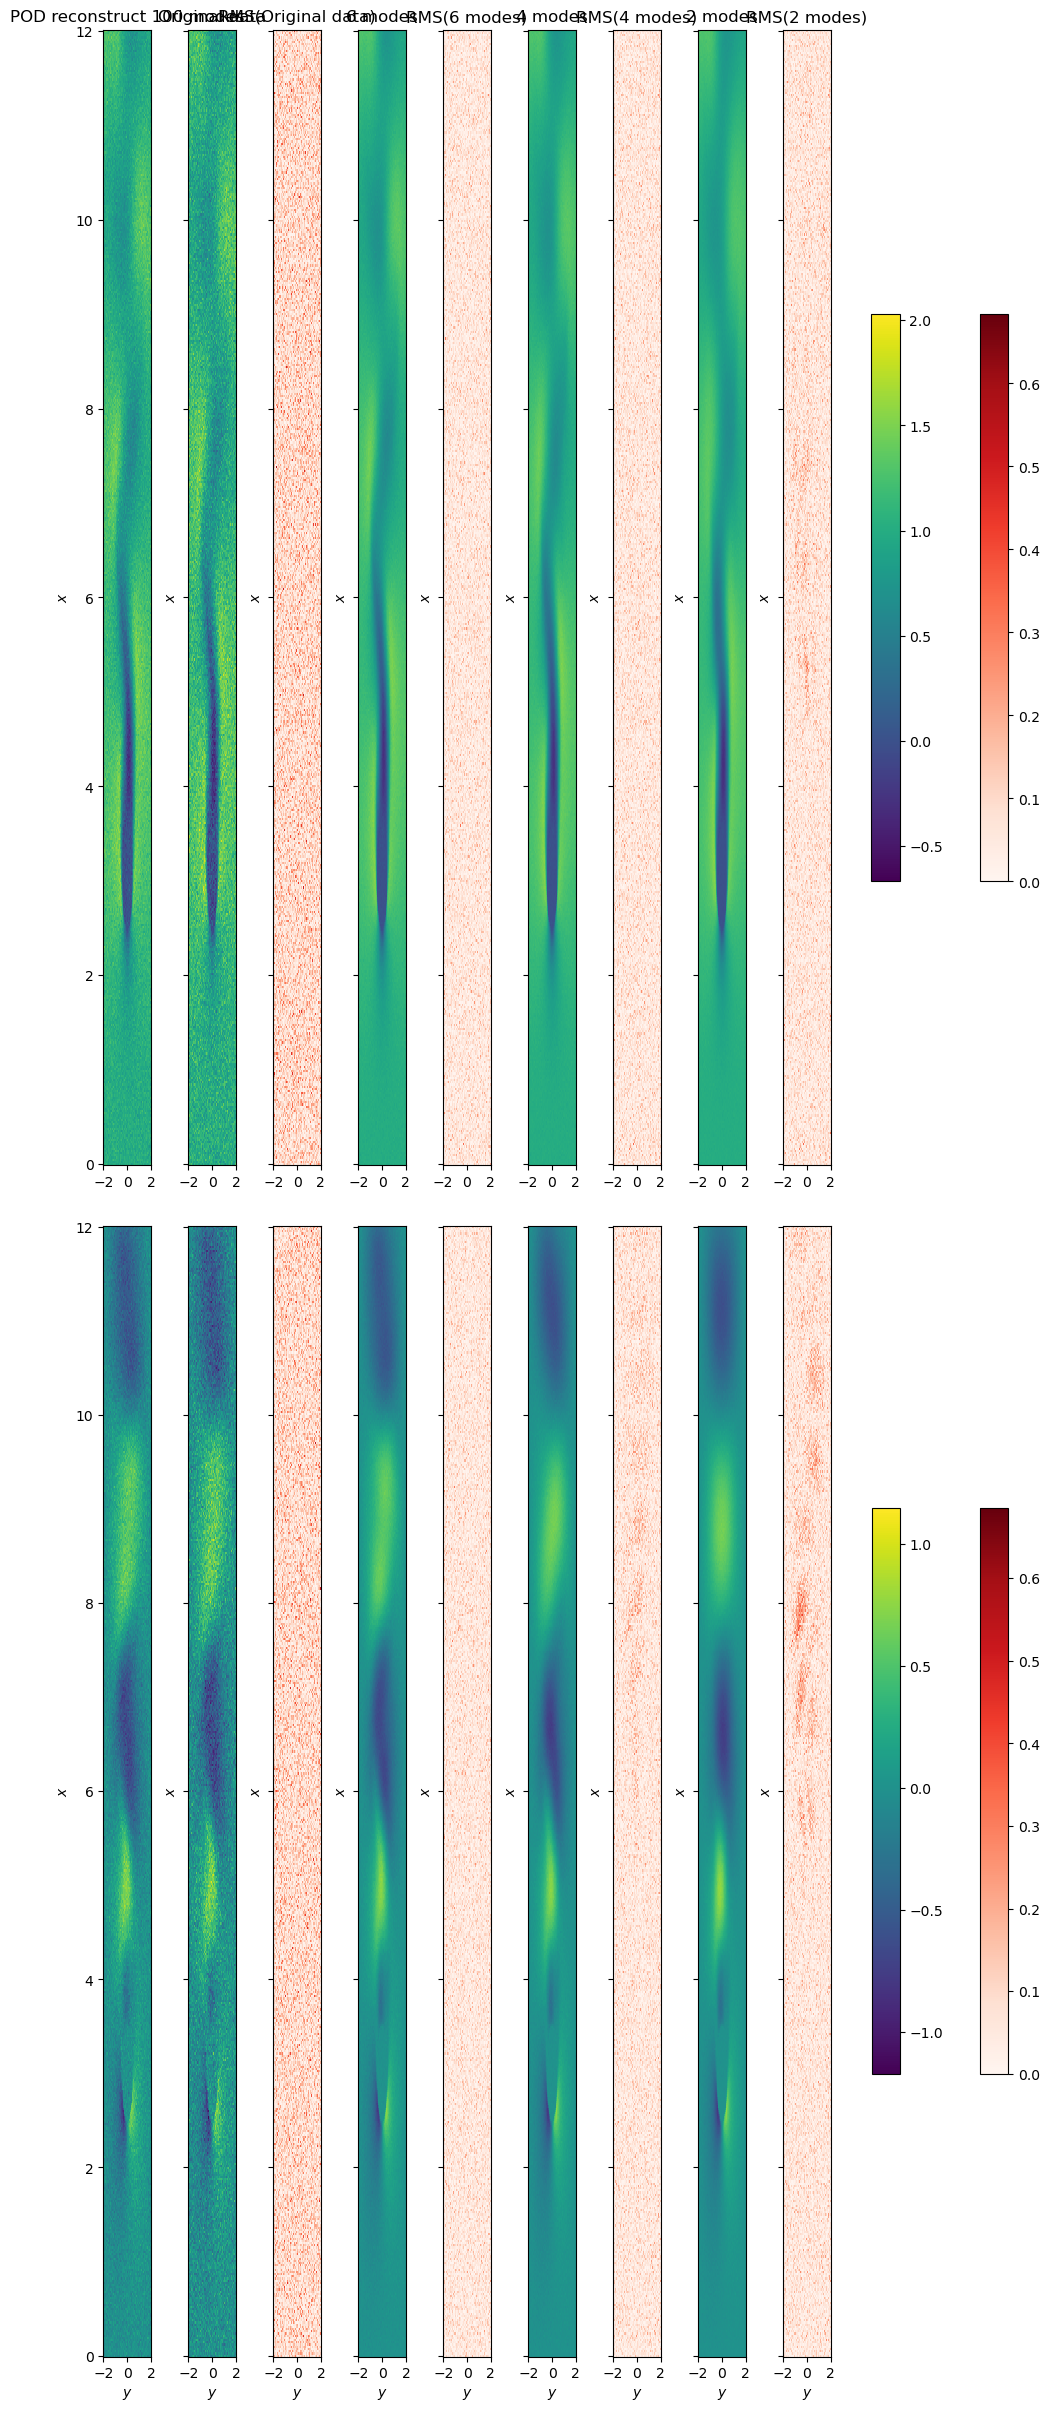

In [ ]:

_case = case_pod.copy()

N_modes = _case.N_modes
datasets = [X_train[..., [-1]]]
names = ['Original data']

for N_modes in [6, 4, 2]:
    # POD case reconstruction
    _case.rerun_POD_decomposition(N_modes=N_modes)
    Q = _case.reconstruct()
    datasets.append(Q)
    names.append(f'{N_modes} modes')
    


POD.plot_flows_rms(case_pod, 
                   datasets=datasets, 
                   names=names, 
                   display_RMS='all');



# Part II. Reduced order modelling via POD-ESN from `src.models_datadriven`<a name="part2"></a>


We have seen that with 4 modes we reconstruct over 95% of the system's energy, which provides a very small reconstruction RMS. Therefore, we select N_modes = 4 for our reduced order model. 




## 2. Initilize POD_ESN instance <a name="part2-2"></a>
- The data provided is used to perform the POD decomposition as well as the ESN training on the POD coefficients.
- If the flag ```train_ESN=False```, only the POD is perfromed and the ESN is not trained

In [ ]:
from src.models_datadriven import POD_ESN

help(POD_ESN)

Help on class POD_ESN in module src.models_datadriven:

class POD_ESN(ESN_model, src.ML_models.POD.POD)
 |  POD_ESN(data, dt, plot_case=False, pdf_file=None, skip_sensor_placement=False, train_ESN=True, domain_of_measurement=None, down_sample_measurement=None, **kwargs)
 |  
 |  Performs POD for a data matrix and trains an ESN to forecast the POD
 |  temporal coefficients.
 |  
 |  
 |  D(x,t) = Σ_j σ_j φ_j(x) ψ_j(t)    for  j = 0, ..., N_modes-1
 |  
 |  [latex]
 |  D(x,t) = \sum_j \sigma_j \phi_j(x) \psi_j(t) \quad \text{for} \quad j = 0, \ldots, N_\mathrm{modes}-1
 |  
 |  POD properties:
 |      - Psi: temporal basis [N, N_modes], with N = Ndim x Nx x Ny
 |      - Phi: spatial basis [Nt, N_modes]
 |      - Sigma: POD Sigmas [N_modes, ],  note: Lambdas can be computed as: Sigma = np.sqrt(Lambda)
 |  
 |  Method resolution order:
 |      POD_ESN
 |      ESN_model
 |      src.ML_models.EchoStateNetwork.EchoStateNetwork
 |      src.model.Model
 |      src.ML_models.POD.POD
 |      buil

In [ ]:
X_train.shape

(2, 129, 513, 400)

In [ ]:
N_train = X_train.shape[-1]
dt = 0.01  # time step size

case_ESN = POD_ESN(data=X_train, 
                   dt=dt,
                   N_modes=4, 
                   domain  = [-2, 2, 0, 12],
                   # ====== ESN arguments ======== # 
                   train_ESN=True,
                   N_train=.8* N_train,
                   N_val=.2*N_train,
                   N_wash=10,
                   noise=0.1,
                   N_func_evals=26,
                   rho_range=[0.2, 0.9],
                   upsample=2,
                   # ====== Plotting flags ======== # 
                   plot_case=False
                  )
case_ESN_og = case_ESN.copy()

MODULO (MODal mULtiscale pOd) is a software developed at the von Karman Institute to perform data driven modal decomposition of numerical and experimental data. 

Modulo assumes you have a uniform grid. If not, please give the weights as parameters of MODULO!
Computing correlation matrix...
Computing Temporal correlation matrix K ...
Done.
Computing Temporal Basis...
Diagonalizing K...
Done.
Computing Spatial Basis...
Computing Phi from D...
Done.
seed 0 	 Optimal hyperparameters: [0.55, 0.6989700043360187], 1e-12, MSE: -1.5190807260344479
========= POD-ESN model complete =========



## 3. Verify implementation <a name="part2-3"></a>
Check that the POD and POD_ESN cases give the same reconstruction.
The small diferences are due to the lack of convergence of the POD, as the amount of data used is different. 

Changing the order of dimensions to ensure modes are in the second to last dimension: 1, [1 4]--(1, 4)


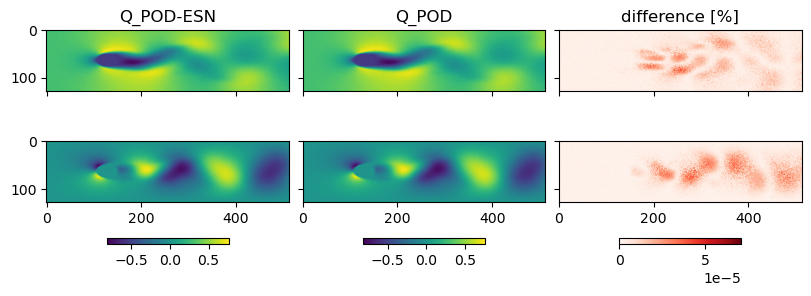

In [ ]:
import matplotlib.pyplot as plt

# POD-ESN reconstruct
Q_esn=case_ESN.reconstruct()


# POD reconstruct
_case = case_pod.copy()
_case.rerun_POD_decomposition(N_modes=case_ESN.N_modes)
Q_ref = _case.reconstruct(Phi=_case.Phi[[len(case_ESN.Phi)-1]])

# Differnce
diff = abs(Q_ref - Q_esn) / np.max(Q_ref, axis=(1,2), keepdims=True) * 100

fig, axs = plt.subplots(2, 3, figsize=(8,3), sharex=True, sharey=True, layout='constrained')
for D, col, cmap, tlt in zip([Q_esn, Q_ref, diff], axs.T, ['viridis', 'viridis', 'Reds'], ['Q_POD-ESN', 'Q_POD', 'difference [%]']):
    for d, ax in zip(D, col):
        im=ax.imshow(d[...,0], cmap=cmap)  
    fig.colorbar(im, ax=col, shrink=.5, orientation='horizontal')
    col[0].set(title=tlt)




## 4. Test forecast of the POD-ESN <a name="part2-4"></a>
We can visualize:
- The temporal evolution of the POD coefficients
- The reconstruction of the flow and its MSE 

In [ ]:
X_test.shape

(2, 129, 513, 400)

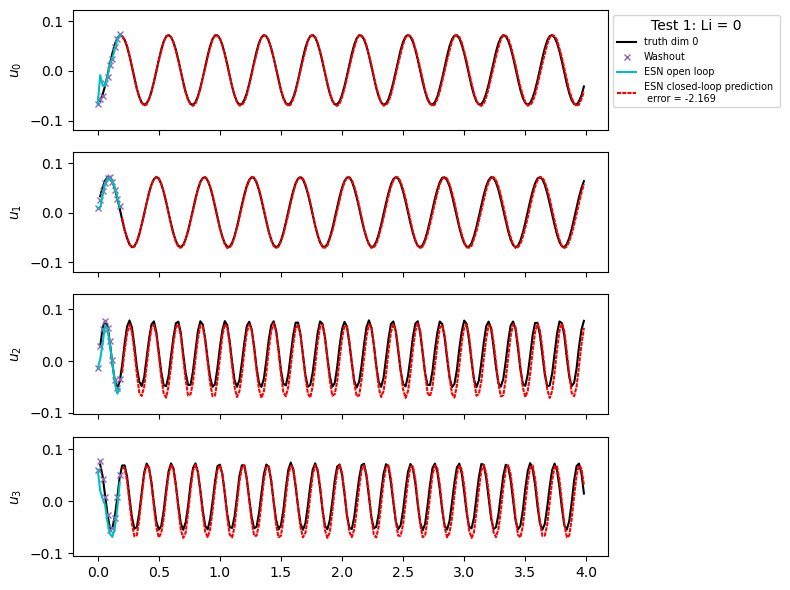

Overall tests min, max and mean MSE in 1 tests = -2.169, -2.169, -2.169.


In [ ]:

U_test = X_test.reshape(case_ESN.Q_mean.shape[0], -1) - case_ESN.Q_mean

# Compare the POD coefficients
Phi_true = case_ESN.project_data_onto_Psi(data=U_test)
# Add noise to the test data
Phi_noisy =  Phi_true.copy()
rng_noise = np.random.default_rng(0)
U_std = np.std(Phi_true, axis=0)
for dd in range(Phi_true.shape[1]):
    Phi_noisy[:, dd] += rng_noise.normal(loc=0, scale=0.1 * U_std[dd], size=Phi_true.shape[0])

_case = case_ESN.copy()

_case.run_test(U_test=Phi_noisy[::case_ESN.upsample], 
                  Y_test=Phi_true[::case_ESN.upsample], 
                  Nt_test=len(Phi_noisy), 
                  max_L_tests=1, margin=0.05
                 )

In [ ]:
case_ESN = case_ESN_og.copy()

# === Upsample reference data ===
# t_true = np.arange(X_test.shape[-1]) * case_ESN.dt
# test_data_up = X_test[..., ::case_ESN.upsample]
# test_data_up_true = X_test_true[..., ::case_ESN.upsample]

t_true = np.arange(X_test.shape[-1]) * case_ESN.dt
test_data_up = X_test.copy()
test_data_up_true = X_test_true.copy()


# === Get ESN prediction on the same time ===
state, time = case_ESN.time_integrate(Nt=len(t_true))


print(time.shape, len(t_true))



(400,) 400


Changing the order of dimensions to ensure modes are in the second to last dimension: 1, [400   4]--(400, 4)


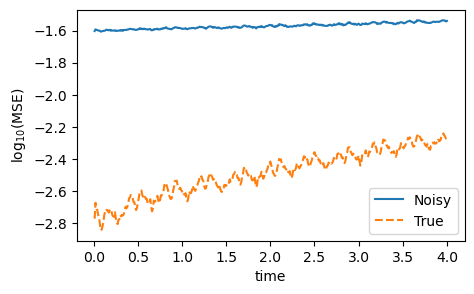

In [ ]:

case_ESN.update_history(state, time)

# Get reconstruction
Phi_ESN = case_ESN.get_POD_coefficients(Nt=-0).squeeze()
prediction = case_ESN.reconstruct(Phi=Phi_ESN[1:])


# Compute the mean square error 
MSE_evolution = POD.compute_MSE(prediction, test_data_up, time_evolution=True)
MSE_evolution_true = POD.compute_MSE(prediction, test_data_up_true, time_evolution=True)
plt.figure(figsize=(5,3))
plt.plot(time, np.log10(MSE_evolution))
plt.plot(time, np.log10(MSE_evolution_true), '--')
plt.gca().set(xlabel='time', ylabel='log$_{10}$(MSE)')
plt.legend(['Noisy', 'True'])

In [ ]:

# Visualize the flow field reconstruction
RMS_noisy = np.array([POD.compute_RMS(test_data_up[...,ti], 
                                          prediction[...,ti]) for ti in range(prediction.shape[-1])])
RMS_true = np.array([POD.compute_RMS(test_data_up_true[...,ti], 
                                      prediction[...,ti]) for ti in range(prediction.shape[-1])])

U_datasets = [test_data_up_true[0].transpose(2,1,0),
              test_data_up[0].transpose(2,1,0),
              prediction[0].transpose(2,1,0), 
              RMS_noisy[:,0].transpose(0,2,1),
              RMS_true[:,0].transpose(0,2,1),
              ]

anim = animate_flowfields(U_datasets, 
                          titles=['Truth', 'Noisy data', 'POD-ESN', 'RMS noisy', 'RMS true'], 
                          n_frames=10)
# anim

In [ ]:
anim

The POD-ESN recovers the true field from a noisy dataset, effectively acting as a de-noiser. Can we achieve this at higher noise levels? How about spatially smoothed or coloured noise? 